### Import libraries and create DataFrame from csv 

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Prompt user for week selection
start_week = int(input("Enter the start week for analysis: "))
end_week = int(input("Enter the end week for analysis (enter the same as start week for single week analysis): "))
weeks = str(start_week) if start_week == end_week else f"{start_week} - {end_week}"

# Function to read, preprocess, group by player, and aggregate data for the selected weeks
def read_data(start_week, end_week):
    data = pd.DataFrame()

    for week in range(start_week, end_week + 1):
        temp_df = pd.read_excel("RB_Data.xlsx", sheet_name=f"Week{week}")

        # Preprocess: Drop irrelevant columns and convert data types
        temp_df.drop(['FL', 'ROST'], axis=1, inplace=True)
        convert = temp_df.select_dtypes('object').columns.difference(['Player'])
        temp_df[convert] = temp_df[convert].apply(lambda x: pd.to_numeric(x.str.replace(',', ''), errors='coerce')).fillna(0)
        temp_df['Rank'] = temp_df['Rank'].astype('Int64')

        # Group by 'Player' and aggregate data
        if data.empty:
            data = temp_df
        else:
            data = data.merge(temp_df, on='Player', suffixes=('', '_week' + str(week)))

    # Apply custom aggregation logic
    for column in data.columns:
        if column.endswith(tuple([f'_week{week}' for week in range(start_week + 1, end_week + 1)])):
            base_column = column.split('_week')[0]
            if base_column in ['Rank', 'Player']:  # Take the latest value
                data[base_column] = data[column]
            elif base_column in ['LG']:  # Take the maximum value
                data[base_column] = data[[base_column, column]].max(axis=1)
            else:  # Sum the values
                data[base_column] += data[column]
            data.drop(column, axis=1, inplace=True)  # Drop the extra week column

    # Calculate 'Y/A' and 'Y/R' based on summed values
    data['Y/A'] = (data['YDS'] / data['ATT']).round(1)
    data['Y/R'] = (data['YDS.1'] / data['REC']).round(1)
    data['FPTS/G'] = (data['FPTS'] / data['G']).round(1)

    return data

# Load and aggregate data for the selected weeks
df = read_data(start_week, end_week)

# Recalculate 'Rank' based on 'FPTS' in descending order
df['Rank'] = df['FPTS'].rank(ascending=False, method='min').astype('int')

# Create 'Weeks' column
if start_week == end_week:
    df['Weeks'] = str(start_week)
else:
    df['Weeks'] = f"{start_week} - {end_week}"

df = df.sort_values(by='Rank')
df.head(10)

,Rank,Player,ATT,YDS,Y/A,LG,20+,TD,REC,TGT,YDS.1,Y/R,TD.1,G,FPTS,FPTS/G,Weeks
2,1,Christian McCaffrey (SF),99,510,5.2,65,8,7,20,24,168,8.4,1,5,133.8,26.8,1 - 5
17,2,Raheem Mostert (MIA),58,314,5.4,43,5,7,15,17,128,8.5,1,5,105.2,21.0,1 - 5
157,3,De'Von Achane (MIA),38,460,12.1,76,17,5,9,11,67,7.4,2,4,101.7,25.4,1 - 5
5,4,Travis Etienne Jr. (JAC),95,396,4.2,35,5,3,18,21,144,8.0,0,5,92.0,18.4,1 - 5
8,5,Kyren Williams (LAR),77,298,3.9,20,1,5,13,24,105,8.1,1,5,89.3,17.9,1 - 5
92,6,Zack Moss (IND),89,445,5.0,56,7,3,8,10,72,9.0,1,4,85.7,21.4,1 - 5
6,7,Bijan Robinson (ATL),67,364,5.4,38,4,0,21,24,146,7.0,2,5,82.0,16.4,1 - 5
16,8,David Montgomery (DET),88,371,4.2,42,3,6,5,9,47,9.4,0,4,80.8,20.2,1 - 5
71,9,D'Andre Swift (PHI),76,434,5.7,43,5,2,15,17,75,5.0,0,5,77.9,15.6,1 - 5
31,10,Josh Jacobs (LV),82,235,2.9,24,1,2,23,30,193,8.4,0,5,77.8,15.6,1 - 5


### Convert relevant stats to a per-game basis and create the final stats for analysis

In [73]:
# Define columns for per-game calculation
per_game = list(df.columns[2:])

# Define columns to exclude from the per-game calculation
exclude_per_game = ['Y/A', 'LG', 'Y/R', 'G', 'FPTS', 'FPTS/G', 'Weeks']

# Create columns and convert stats to a per-game basis for the defined columns, not those in the exclude list
for col in per_game:
    if col not in exclude_per_game:
        df[col + '/game'] = (df[col] / df['G']).round(1)

# Define final columns to be used for analysis, combines excluded and new per-game columns
final_columns = exclude_per_game + [col + '/game' for col in per_game if col not in exclude_per_game]

# Display final columns with 'Rank' and 'Player'
df[['Rank', 'Player'] + final_columns].head(10)

,Rank,Player,Y/A,LG,Y/R,G,FPTS,FPTS/G,Weeks,ATT/game,YDS/game,20+/game,TD/game,REC/game,TGT/game,YDS.1/game,TD.1/game
2,1,Christian McCaffrey (SF),5.2,65,8.4,5,133.8,26.8,1 - 5,19.8,102.0,1.6,1.4,4.0,4.8,33.6,0.2
17,2,Raheem Mostert (MIA),5.4,43,8.5,5,105.2,21.0,1 - 5,11.6,62.8,1.0,1.4,3.0,3.4,25.6,0.2
157,3,De'Von Achane (MIA),12.1,76,7.4,4,101.7,25.4,1 - 5,9.5,115.0,4.2,1.2,2.2,2.8,16.8,0.5
5,4,Travis Etienne Jr. (JAC),4.2,35,8.0,5,92.0,18.4,1 - 5,19.0,79.2,1.0,0.6,3.6,4.2,28.8,0.0
8,5,Kyren Williams (LAR),3.9,20,8.1,5,89.3,17.9,1 - 5,15.4,59.6,0.2,1.0,2.6,4.8,21.0,0.2
92,6,Zack Moss (IND),5.0,56,9.0,4,85.7,21.4,1 - 5,22.2,111.2,1.8,0.8,2.0,2.5,18.0,0.2
6,7,Bijan Robinson (ATL),5.4,38,7.0,5,82.0,16.4,1 - 5,13.4,72.8,0.8,0.0,4.2,4.8,29.2,0.4
16,8,David Montgomery (DET),4.2,42,9.4,4,80.8,20.2,1 - 5,22.0,92.8,0.8,1.5,1.2,2.2,11.8,0.0
71,9,D'Andre Swift (PHI),5.7,43,5.0,5,77.9,15.6,1 - 5,15.2,86.8,1.0,0.4,3.0,3.4,15.0,0.0
31,10,Josh Jacobs (LV),2.9,24,8.4,5,77.8,15.6,1 - 5,16.4,47.0,0.2,0.4,4.6,6.0,38.6,0.0


### Calculate the correlations for the final stats across different conditions

In [74]:
# Define columns and columns to exclude for correlation calculation, from final columns
exclude_corr = ['FPTS/G', 'FPTS', 'G', 'Weeks']
corr_columns = [col for col in final_columns if col not in exclude_corr]

# Define a function to calculate correlations
def compute_correlations(dataframe, corr_columns):
    return dataframe[corr_columns].corrwith(dataframe['FPTS/G'])

# Compute correlations for various conditions
corr_all = compute_correlations(df, corr_columns)
corr_nonzero = compute_correlations(df[df['FPTS/G'] > 0], corr_columns)
corr_top50 = compute_correlations(df[df['Rank'] <= 50], corr_columns)
corr_top25 = compute_correlations(df[df['Rank'] <= 25], corr_columns)

# Compile all correlations into a DataFrame for comparison
df_corr = pd.DataFrame({
    'All Players': corr_all,
    'FPTS > 0': corr_nonzero,
    'Top 50 Players': corr_top50,
    'Top 25 Players': corr_top25
})

# Calculate the average correlation across the four conditions, adding 'Average' column to DataFrame
df_corr['Correlation'] = df_corr.mean(axis=1)

df_corr.round(2)

,All Players,FPTS > 0,Top 50 Players,Top 25 Players,Correlation
Y/A,0.50,0.49,0.48,0.47,0.49
LG,0.77,0.75,0.61,0.51,0.66
Y/R,0.12,0.12,0.26,0.17,0.17
ATT/game,0.86,0.85,0.65,0.39,0.69
YDS/game,0.93,0.93,0.86,0.77,0.87
20+/game,0.66,0.66,0.67,0.59,0.64
TD/game,0.81,0.81,0.81,0.86,0.82
REC/game,0.75,0.73,0.45,0.11,0.51
TGT/game,0.77,0.74,0.46,0.08,0.51
YDS.1/game,0.79,0.77,0.56,0.22,0.58


### Assign the weights for the final stats

In [75]:
# Calculate R^2 for the 'Average' correlation, adding 'R^2' column to DataFrame
df_corr['R^2'] = df_corr['Correlation'] ** 2

# Define the calculation to assign weights
def weight_calc(row):
    if row['Correlation'] >= 0.69:
        return 1 + row['R^2']
    else:
        return 1
    
# Assign weights based on the given criteria, adding 'Weight' column to DataFrame
df_corr['Weight'] = df_corr.apply(weight_calc, axis=1)

# Display the new columns in the DataFrame
df_corr[['Correlation', 'R^2', 'Weight']].round(2)

,Correlation,R^2,Weight
Y/A,0.49,0.24,1.00
LG,0.66,0.44,1.00
Y/R,0.17,0.03,1.00
ATT/game,0.69,0.47,1.00
YDS/game,0.87,0.76,1.76
20+/game,0.64,0.42,1.00
TD/game,0.82,0.67,1.67
REC/game,0.51,0.26,1.00
TGT/game,0.51,0.26,1.00
YDS.1/game,0.58,0.34,1.00


### Multiply the assigned weights to the final stats

In [76]:
# Multiply each relevant column by its corresponding weight
for col in corr_columns:
    weight = df_corr.loc[col, 'Weight']
    df[col + '_weighted'] = (df[col] * weight).round(1)

# Extract the weighted columns
weight_columns = [col + '_weighted' for col in corr_columns]

# Display the new weighted stats columns
df[['Rank', 'Player', 'FPTS/G'] + weight_columns].head(10)

,Rank,Player,FPTS/G,Y/A_weighted,LG_weighted,Y/R_weighted,ATT/game_weighted,YDS/game_weighted,20+/game_weighted,TD/game_weighted,REC/game_weighted,TGT/game_weighted,YDS.1/game_weighted,TD.1/game_weighted
2,1,Christian McCaffrey (SF),26.8,5.2,65.0,8.4,19.8,179.4,1.6,2.3,4.0,4.8,33.6,0.2
17,2,Raheem Mostert (MIA),21.0,5.4,43.0,8.5,11.6,110.5,1.0,2.3,3.0,3.4,25.6,0.2
157,3,De'Von Achane (MIA),25.4,12.1,76.0,7.4,9.5,202.3,4.2,2.0,2.2,2.8,16.8,0.5
5,4,Travis Etienne Jr. (JAC),18.4,4.2,35.0,8.0,19.0,139.3,1.0,1.0,3.6,4.2,28.8,0.0
8,5,Kyren Williams (LAR),17.9,3.9,20.0,8.1,15.4,104.8,0.2,1.7,2.6,4.8,21.0,0.2
92,6,Zack Moss (IND),21.4,5.0,56.0,9.0,22.2,195.6,1.8,1.3,2.0,2.5,18.0,0.2
6,7,Bijan Robinson (ATL),16.4,5.4,38.0,7.0,13.4,128.0,0.8,0.0,4.2,4.8,29.2,0.4
16,8,David Montgomery (DET),20.2,4.2,42.0,9.4,22.0,163.2,0.8,2.5,1.2,2.2,11.8,0.0
71,9,D'Andre Swift (PHI),15.6,5.7,43.0,5.0,15.2,152.7,1.0,0.7,3.0,3.4,15.0,0.0
31,10,Josh Jacobs (LV),15.6,2.9,24.0,8.4,16.4,82.7,0.2,0.7,4.6,6.0,38.6,0.0


### Display the columns potentially to be included in the average weighted score

In [77]:
high_corr = df_corr[df_corr['Correlation'] >= 0.69].index.tolist()
conditional_columns = [col + '_weighted' for col in high_corr if col + '_weighted' in df.columns]

# Include 'FPTS/G' in columns to be used for the average weighted score
conditional_columns.append('FPTS/G')

conditional_columns

['YDS/game_weighted', 'TD/game_weighted', 'FPTS/G']

### Define the columns to be used for the average weighted score

In [78]:
# Define select columns to be used for the average weighted score
avg = ['ATT/game_weighted',
 'YDS/game_weighted',
 'TD/game_weighted',
 'REC/game_weighted',
 'TGT/game_weighted',
 'YDS.1/game_weighted',
 'FPTS/G']

### Calculate each player's average weighted score and rank them from high to low

In [79]:
# Calculate the average weighted score for the select columns
df['Score'] = df[avg].mean(axis=1).round(1)

# Rank both of the average weighted scores with NaN handling
df['Final Rank'] = df.sort_values('Score', ascending=False)\
                ['Score'].rank(method='first', ascending=False, na_option='bottom').astype(int)

# Calculate the variance in ranking both ranks
df['Variance'] = df['Rank'] - df['Final Rank']

### Display results of the average weighted score and rank

In [80]:
# Display the results for the select columns
analysis = df[['Rank', 'Final Rank', 'Player', 'Score', 'Variance'] + final_columns]
analysis.set_index('Rank', inplace=True)
analysis = analysis.sort_values(by='Final Rank', ascending=True)
analysis.head(30)

,Final Rank,Player,Score,Variance,Y/A,LG,Y/R,G,FPTS,FPTS/G,Weeks,ATT/game,YDS/game,20+/game,TD/game,REC/game,TGT/game,YDS.1/game,TD.1/game
Rank,,,,,,,,,,,,,,,,,,,
50,1,Austin Ekeler (LAC),43.7,49,7.3,55,11.8,1,26.4,26.4,1 - 5,16.0,117.0,4.0,1.0,4.0,5.0,47.0,0.0
1,2,Christian McCaffrey (SF),38.7,-1,5.2,65,8.4,5,133.8,26.8,1 - 5,19.8,102.0,1.6,1.4,4.0,4.8,33.6,0.2
6,3,Zack Moss (IND),37.6,3,5.0,56,9.0,4,85.7,21.4,1 - 5,22.2,111.2,1.8,0.8,2.0,2.5,18.0,0.2
3,4,De'Von Achane (MIA),37.3,-1,12.1,76,7.4,4,101.7,25.4,1 - 5,9.5,115.0,4.2,1.2,2.2,2.8,16.8,0.5
8,5,David Montgomery (DET),31.9,3,4.2,42,9.4,4,80.8,20.2,1 - 5,22.0,92.8,0.8,1.5,1.2,2.2,11.8,0.0
4,6,Travis Etienne Jr. (JAC),30.6,-2,4.2,35,8.0,5,92.0,18.4,1 - 5,19.0,79.2,1.0,0.6,3.6,4.2,28.8,0.0
9,7,D'Andre Swift (PHI),29.4,2,5.7,43,5.0,5,77.9,15.6,1 - 5,15.2,86.8,1.0,0.4,3.0,3.4,15.0,0.0
7,8,Bijan Robinson (ATL),28.0,-1,5.4,38,7.0,5,82.0,16.4,1 - 5,13.4,72.8,0.8,0.0,4.2,4.8,29.2,0.4
31,9,Alvin Kamara (NO),27.7,22,4.0,13,3.1,2,40.1,20.0,1 - 5,16.5,65.5,0.0,0.5,8.0,8.5,25.0,0.0


### Compare per-game stats of two players and visualize the results

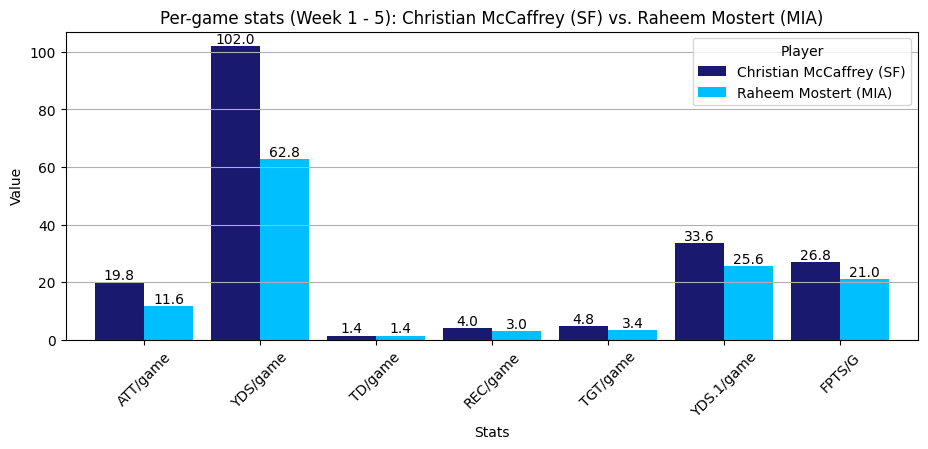

,Final Rank,Y/A,LG,Y/R,G,FPTS,FPTS/G,Weeks,ATT/game,YDS/game,20+/game,TD/game,REC/game,TGT/game,YDS.1/game,TD.1/game
Player,,,,,,,,,,,,,,,,
Christian McCaffrey (SF),2,5.2,65,8.4,5,133.8,26.8,1 - 5,19.8,102.0,1.6,1.4,4.0,4.8,33.6,0.2
Raheem Mostert (MIA),13,5.4,43,8.5,5,105.2,21.0,1 - 5,11.6,62.8,1.0,1.4,3.0,3.4,25.6,0.2


In [81]:
# Prompt the user to input the name of the players
player1 = input("Enter player 1 name")
player2 = input("Enter player 2 name")

# Extract and reorder rows for the two specified players
# Filter rows where the 'Player' column contains the names entered by the user
players = df[df['Player'].str.contains(player1) | df['Player'].str.contains(player2)]
players.set_index('Player', inplace=True)
player1_match = players.index[0] if player1 in players.index[0] else players.index[1]
player2_match = players.index[1] if player2 in players.index[1] else players.index[0]
players = players.reindex([player1_match, player2_match])

# Define columns to be compared
compare_columns = [col.replace('_weighted', '') for col in avg]

# Define a function to compare per-game stats of two players
def compare(player1, player2):

    # Plot the data
    chart = players[compare_columns].T.plot(kind='bar',
                                            color=['midnightblue', 'deepskyblue'],
                                            width=0.85,
                                            figsize=(11,4))

    # Format chart
    plt.title(f'Per-game stats (Week {weeks}): {player1} vs. {player2}')
    plt.xlabel('Stats')
    plt.ylabel('Value')
    plt.grid(axis='y')
    plt.xticks(rotation=45)

    # Add data labels above the bars
    for p in chart.patches:
        chart.annotate(f'{p.get_height():.1f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 5), 
                    textcoords = 'offset points')

    plt.show()

# Call the 'compare' function which creates and displays the visualization
compare(player1_match, player2_match)
players[['Final Rank'] + final_columns]